In [2]:
# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from pycbc.types.array_cuda import inner
from scipy.signal import welch, firwin2, fftconvolve,stft,filtfilt
from scipy.io import savemat,loadmat
from scipy.interpolate import interp1d
from scipy.signal import find_peaks


像参数I和Δtd分别为：
I:0.6187，Δtd:19.7050


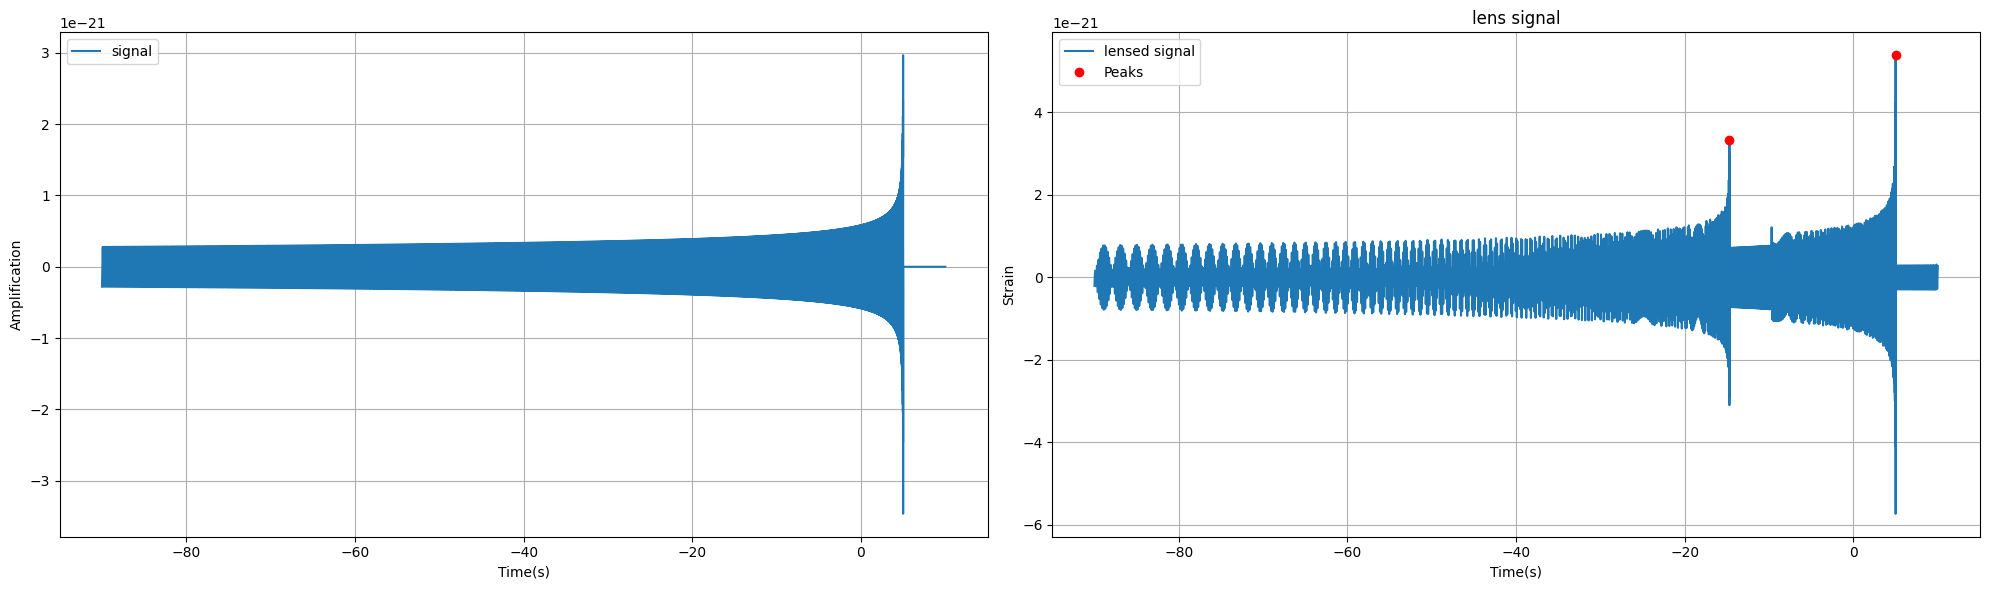

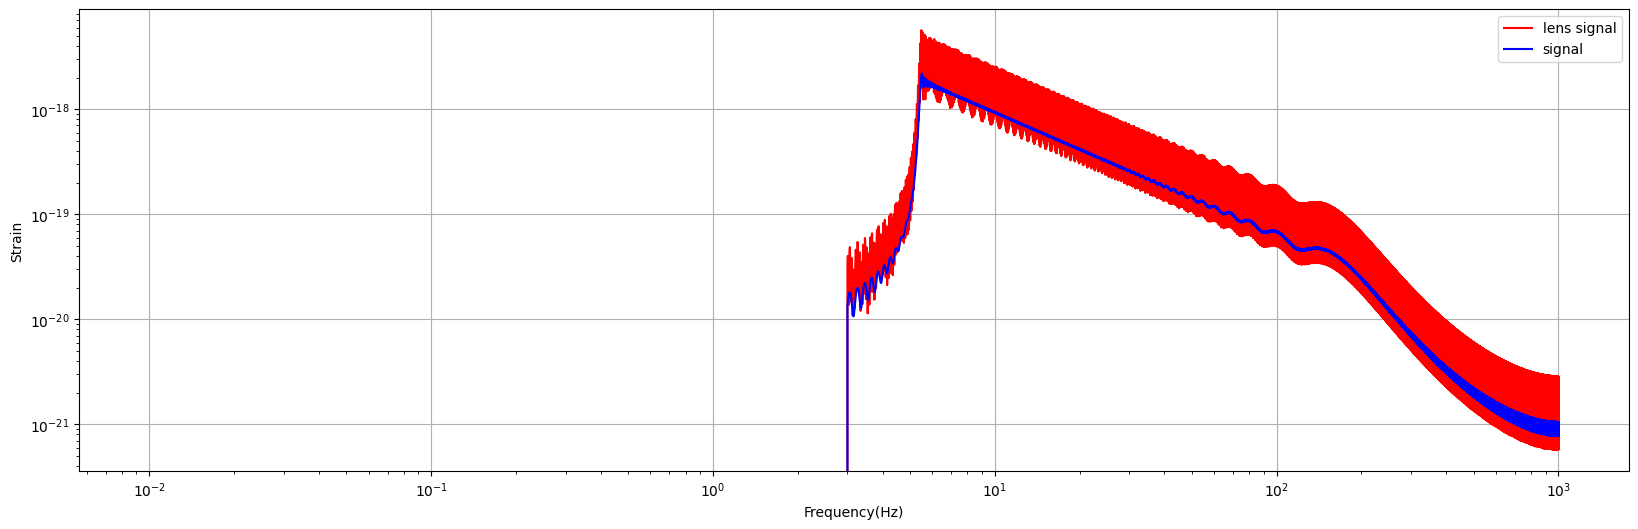

参数信息：
r: 100.0000 Mpc
m_c: 13.4881 M_sun
t_c: 5.0 s
phi_c: 1.0 π
Mlz: 1.0000e+06 M_sun
y: 0.5


In [3]:
# 常量定义
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 10 * M_sun  # 增大质量使频率降低
M2 = 25 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2  # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
r = 100 * 1e6 * pc  # 引力波源到观测者的距离，单位Mpc
t_c = 5.0  # 合并时间
phi_c = 1 * np.pi  # 合并时刻的相位

# 降低采样率，增加时间范围，使波形变化更平缓
deltaT = 0.0005   # 采样率Hz
t = np.arange(-90, 10, deltaT)  # 增加时间范围，让信号有更多的低频部分

# 定义引力波信号函数
def generate_h_t(t, M_c, r, phi_c, t_c):
    if t < t_c:
        theta_t = c**3 * (t_c - t) / (5 * G * M_c)
        if theta_t > 10:
            h = G * M_c / (c**2 * r) * theta_t**(-1/4) * np.cos(2*phi_c - 2*theta_t**(5/8))
        else:
            h = 0
    else:
        h = 0
    return h

# 向量化函数
h = np.zeros_like(t, dtype=float)
for i, ti in enumerate(t):
    h[i] = generate_h_t(ti, M_c, r, phi_c, t_c)

# 去除可能的无穷大或NaN值
h = np.nan_to_num(h)

# 将信号转换到频域
h_f = np.fft.rfft(h)

# 生成频率
freqs = np.fft.rfftfreq(len(h), deltaT)

# 添加3Hz的低频截止
low_freq_cutoff = 3.0  # Hz
freq_mask = freqs >= low_freq_cutoff
h_f[~freq_mask] = 0  # 将3Hz以下的频率分量置零

# 透镜参数定义
Mlz = 1e6 * M_sun
omega = 2 * np.pi * freqs
w = G * 4 * Mlz * omega / c**3
y = 0.5

# 定义光学极限的透镜化SIS模型
def generate_f_geo(w, y):
    F_geo = np.ones_like(w, dtype=complex)
    for i, wi in enumerate(w):
        if y < 1:
            F_geo[i] = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1/y) * np.exp(1j * wi * 2 * y)
        else:
            F_geo[i] = np.sqrt(1 + 1/y)
    return F_geo

# 生成透镜化，频域
F_geo = generate_f_geo(w, y)

# 将信号透镜化（频域）
lens_f = h_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f)

# 检测峰值
peaks, properties = find_peaks(h_lens, height=1e-22, distance=1000)
peak_times = t[peaks]
peak_values = h_lens[peaks]

# 只取两个最显著的峰值
sorted_peaks = sorted(zip(peak_times, peak_values), key=lambda x: abs(x[1]), reverse=True)
top_two_peaks = sorted_peaks[:2]

# 打印结果
print("像参数I和Δtd分别为：")
print(f'I:{(top_two_peaks[1][1]/top_two_peaks[0][1]):.4f}，Δtd:{(top_two_peaks[0][0] - top_two_peaks[1][0]):.4f}')
    
# 绘图
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(t, h, label='signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, h_lens, label='lensed signal')
plt.plot([p[0] for p in top_two_peaks], [p[1] for p in top_two_peaks], 'ro', label='Peaks')
plt.xlabel('Time(s)')
plt.ylabel('Strain')
plt.title('lens signal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 频域表示
plt.figure(figsize=(20, 6))
plt.plot(freqs, np.abs(lens_f), 'red', label='lens signal')
plt.plot(freqs, np.abs(h_f), 'blue', label='signal')
plt.legend()
plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.grid(True)
plt.show()

# 打印参数
print(f"参数信息：")
print(f"r: {r / 1e6 / pc:.4f} Mpc")
print(f"m_c: {M_c/M_sun:.4f} M_sun")
print(f"t_c: {t_c} s")
print(f"phi_c: {phi_c / np.pi} π")
print(f"Mlz: {Mlz/M_sun:.4e} M_sun")
print(f"y: {y}")

## LIGO提供的PSD相关数据

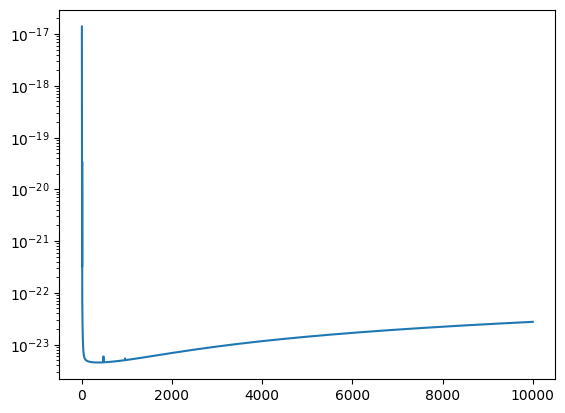

In [4]:
# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')
posfreqs = freq_psd[:,0]
psd_txt = freq_psd[:,1]
plt.plot(posfreqs,psd_txt)
plt.yscale('log')

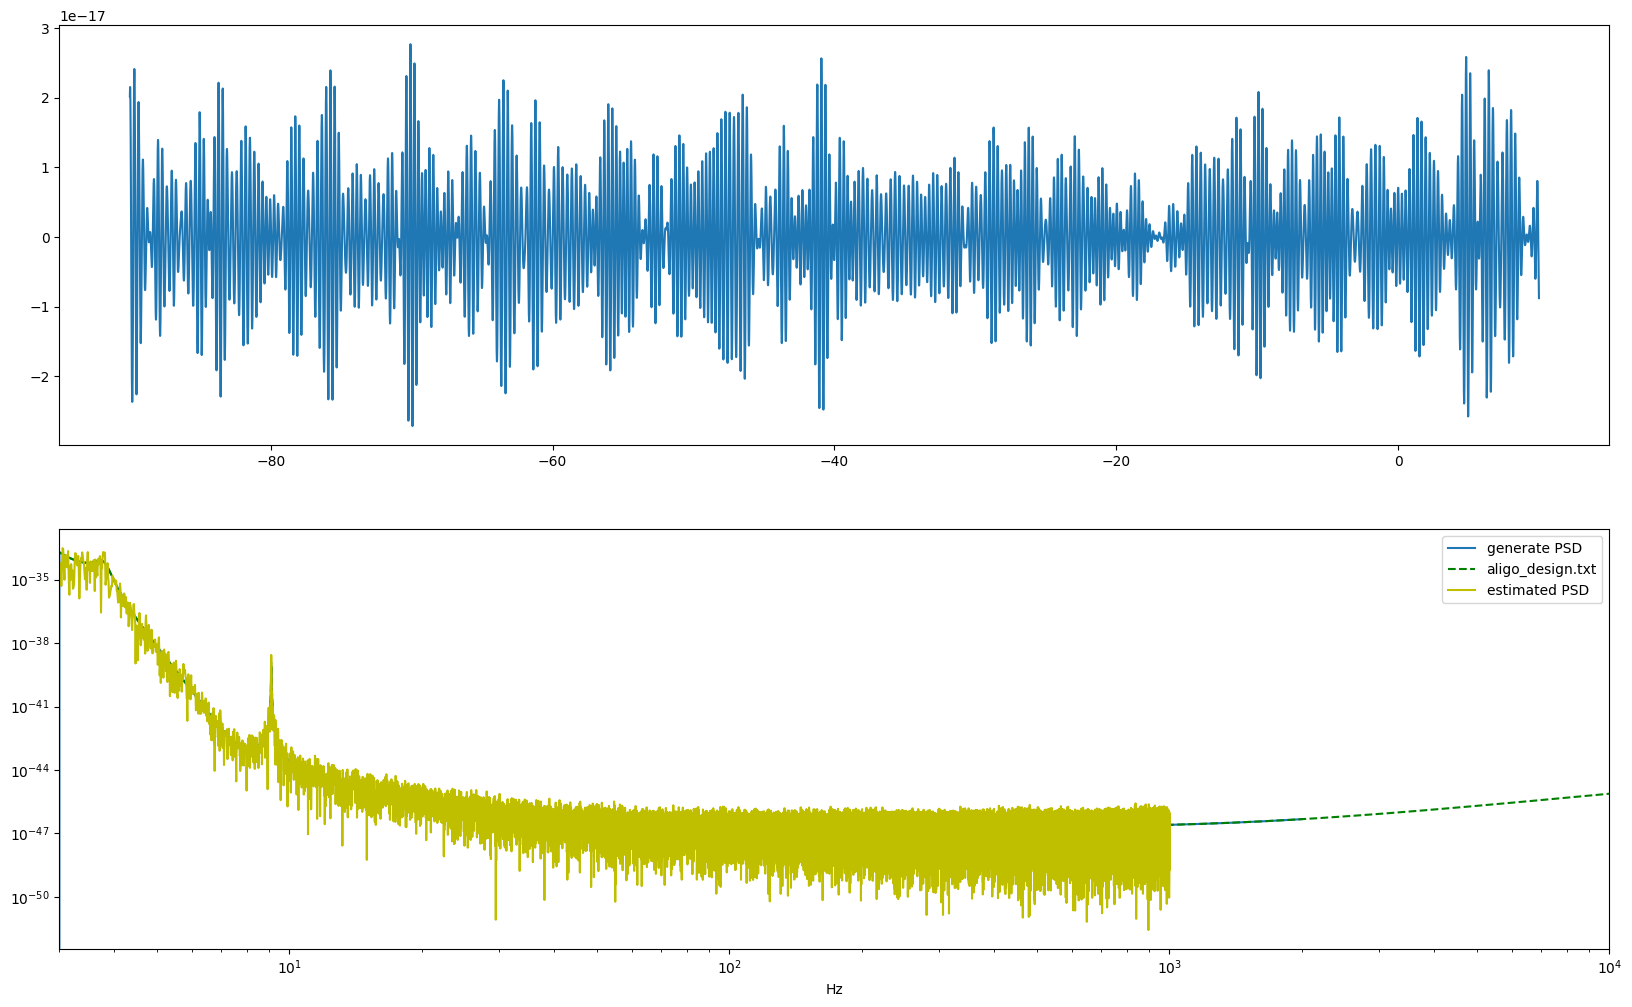

In [5]:
import pycbc.psd
import pycbc.noise
import pycbc.types
filename = 'aligo_design.txt'

delta_f = 1.0 / 100
samples = 2000
length = int(samples / delta_f)
low_frequency_cutoff = 3.0
# The PSD will be interpolated to the requested frequency spacing(按照要求的频率间隔进行插值)
# 如果是asd，则进行平方操作
psd = pycbc.psd.from_txt(filename, length, delta_f,
                         low_frequency_cutoff, is_asd_file=True)
fig = plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
delta_t = 1/samples 
outNoise = pycbc.noise.noise_from_psd(length, delta_t, psd,seed = 516)

estimated_psd = pycbc.psd.welch(outNoise,int(100/delta_t),int(100/delta_t/2))
plt.plot(t,outNoise,label = 'signal')
plt.subplot(2,1,2)
plt.loglog(psd.sample_frequencies, psd, label='generate PSD')
plt.xlim(xmin=3, xmax=10000)
plt.loglog(posfreqs,psd_txt ** 2, 'g--',label='aligo_design.txt')
plt.yscale('log')
plt.xlabel('Hz')
plt.plot(estimated_psd.sample_frequencies,estimated_psd,'y',label='estimated PSD')
plt.legend()
plt.show()


PSD range: 1e-47 to 2.7511432719992743e-42


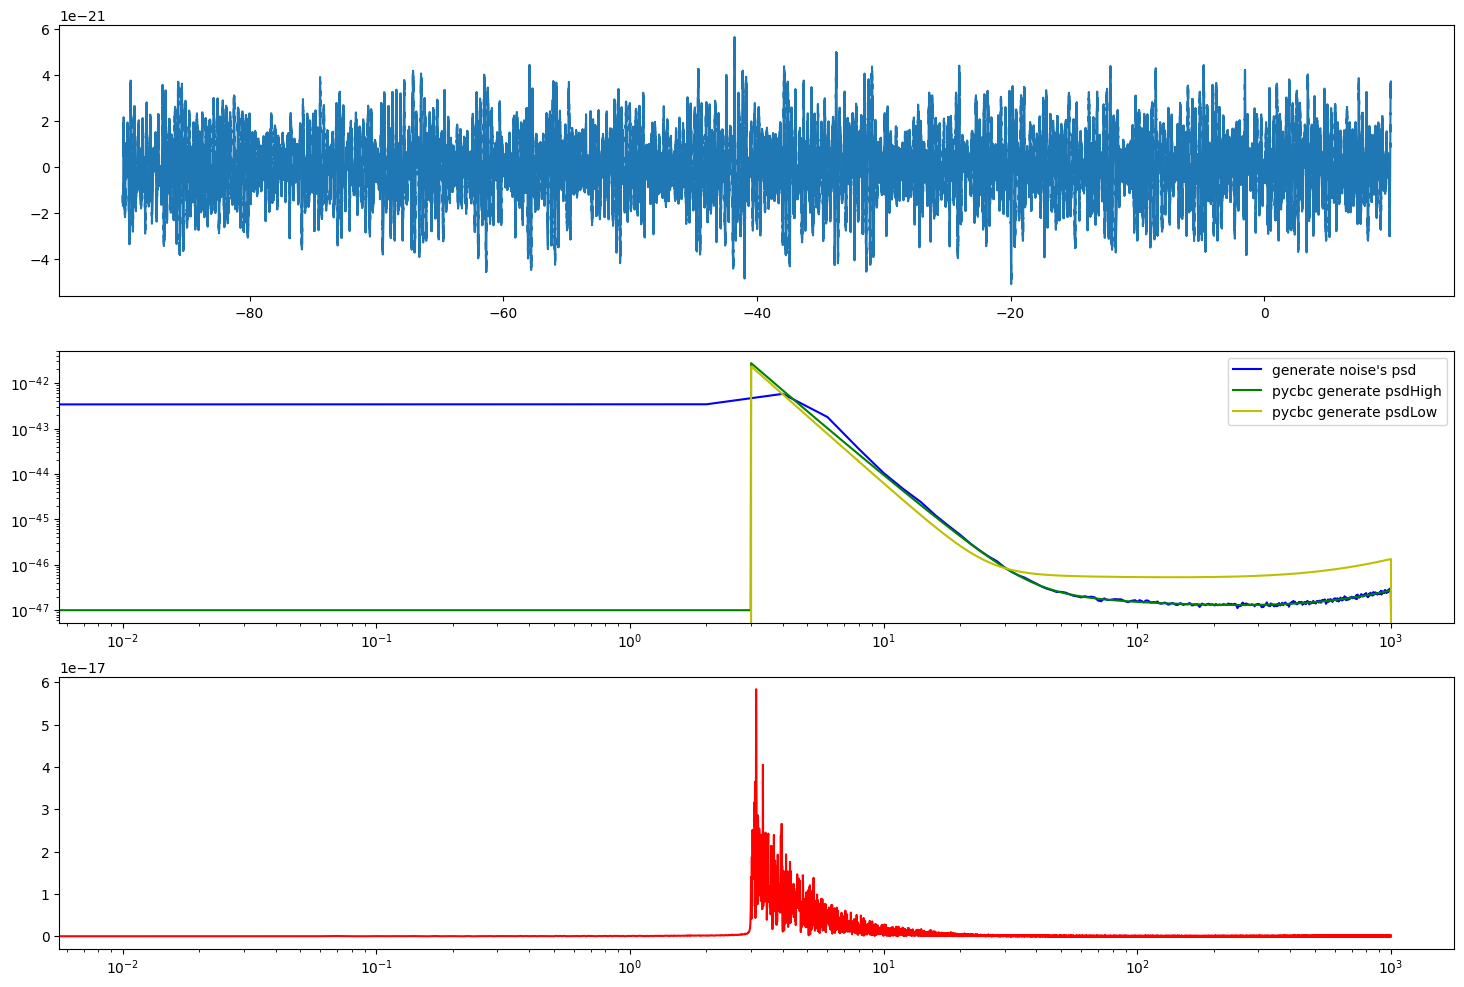

In [24]:
import matplotlib.pyplot as plt
import pycbc.noise
import pycbc.psd
import numpy as np
from scipy.signal import welch

flow = 3  # 最低频率为3Hz
delta_f = 1.0 / 100  # 频率分辨率
nyq_freq = 1000
flen = int(nyq_freq / delta_f) + 1

# 生成PSD
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# 设置最小阈值
min_threshold = 1e-47  # 可以根据需要调整这个值
psdHigh = pycbc.types.FrequencySeries(
    np.maximum(psdHigh.data, min_threshold),
    delta_f=psdHigh.delta_f,
    epoch=psdHigh.epoch
)

# 使用.data访问底层数组
print("PSD range:", np.min(psdHigh.data), "to", np.max(psdHigh.data))

# 其余代码保持不变
psdLow = pycbc.psd.from_string('aLIGOZeroDetLowPower', flen, delta_f, flow)
# psd = psdHigh + psdLow
# 噪声参数
delta_t = 1.0 / 2000
tsamples = 200000
duration = tsamples * delta_t
samples = tsamples / duration

outNoise = pycbc.noise.noise_from_psd(tsamples,delta_t,psdHigh,seed= 123)
freqs = np.fft.rfftfreq(len(outNoise),t[1]-t[0])

f,pxx = welch(outNoise,fs = samples,nperseg=samples/2)
f_noise = np.fft.rfft(outNoise)
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(t,outNoise)

plt.subplot(312)
plt.plot(f,pxx,'b',label = "generate noise's psd")
# plt.plot(freqs,psd,'r',label = "psd = psdHigh + psdLow")
plt.plot(freqs,psdHigh,'g',label = "pycbc generate psdHigh")
plt.plot(freqs,psdLow,'y',label = "pycbc generate psdLow")
plt.yscale('log')
# plt.xlim(low_frequency_cutoff,nyq_freq)
plt.legend()
plt.xscale('log')
plt.subplot(313)
plt.plot(freqs,np.abs(f_noise),'r')
plt.xscale('log')
plt.show()
savemat('noise.mat',{'noise':outNoise})

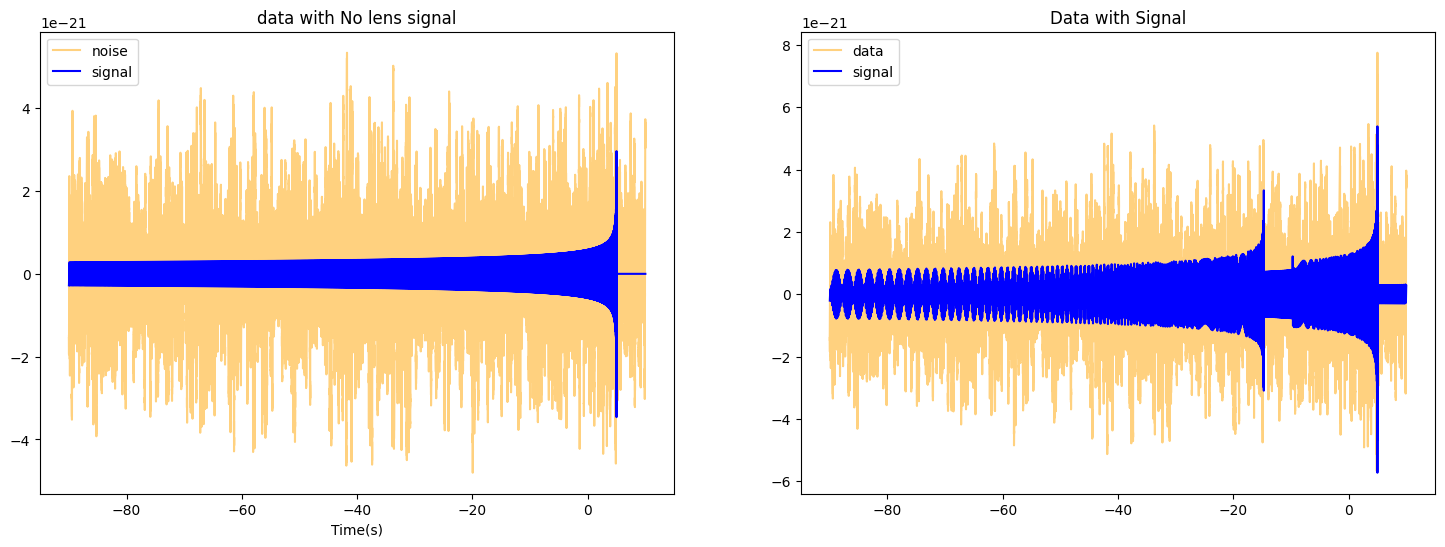

In [25]:
# h = h[:len(output_noise)]
# data = h + output_noise

data = h_lens + outNoise
data_no_lens = h + outNoise

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图
axs[0].plot(t, data_no_lens, "orange", label="noise", alpha=0.5)
axs[0].plot(t, h, "blue", label='signal')
axs[0].set_xlabel("Time(s)")
axs[0].set_title("data with No lens signal")
axs[0].legend()

# 第二个子图
axs[1].plot(t, data, "orange", label="data", alpha=0.5)
axs[1].plot(t, h_lens, "blue", label='signal')
axs[1].set_title("Data with Signal")
axs[1].legend()

plt.show()

savemat('data.mat',{'data':data,'samples':samples})
savemat('data_No_lens.mat',{'data':data_no_lens,'samples':samples})
# print(np.isinf(data).any())

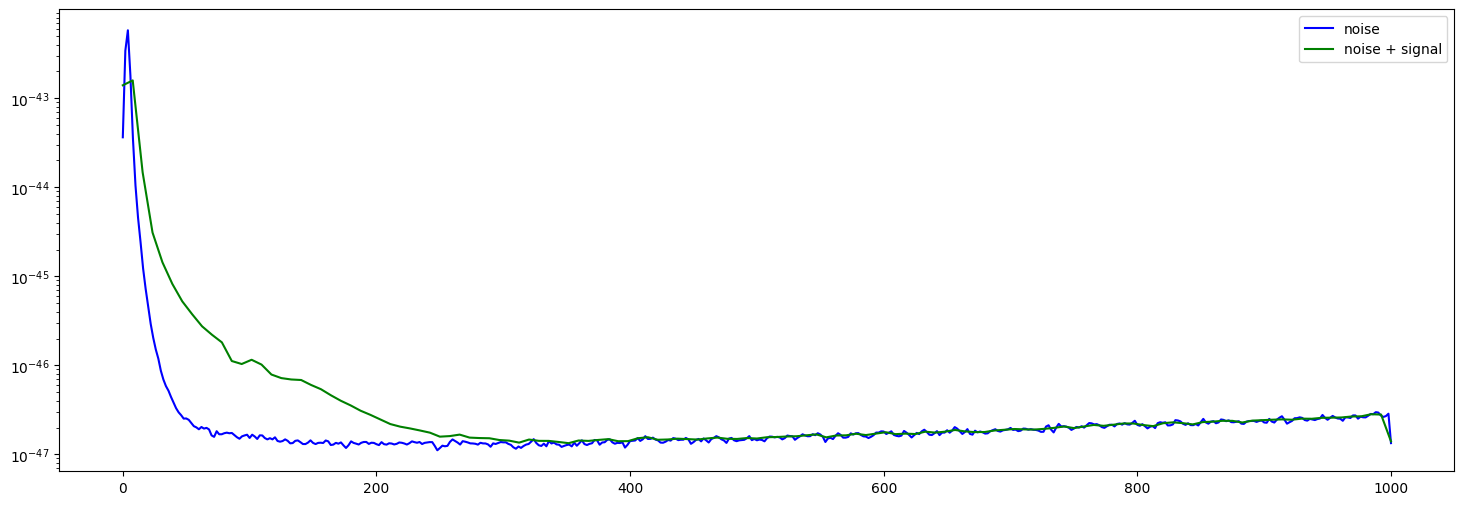

In [26]:
[f_data,pxx_data] = welch(data,fs = samples,window = "hamming",nperseg=256,noverlap=None,nfft=None,detrend = False)

fig = plt.figure(figsize=(18,6))
plt.plot(f,pxx,'blue',label = 'noise')
plt.plot(f_data,pxx_data,"green",label = 'noise + signal')
plt.yscale('log')
plt.legend()
# plt.xlim(0,250)
plt.show()


信号匹配度分析：
Match value: 0.8660


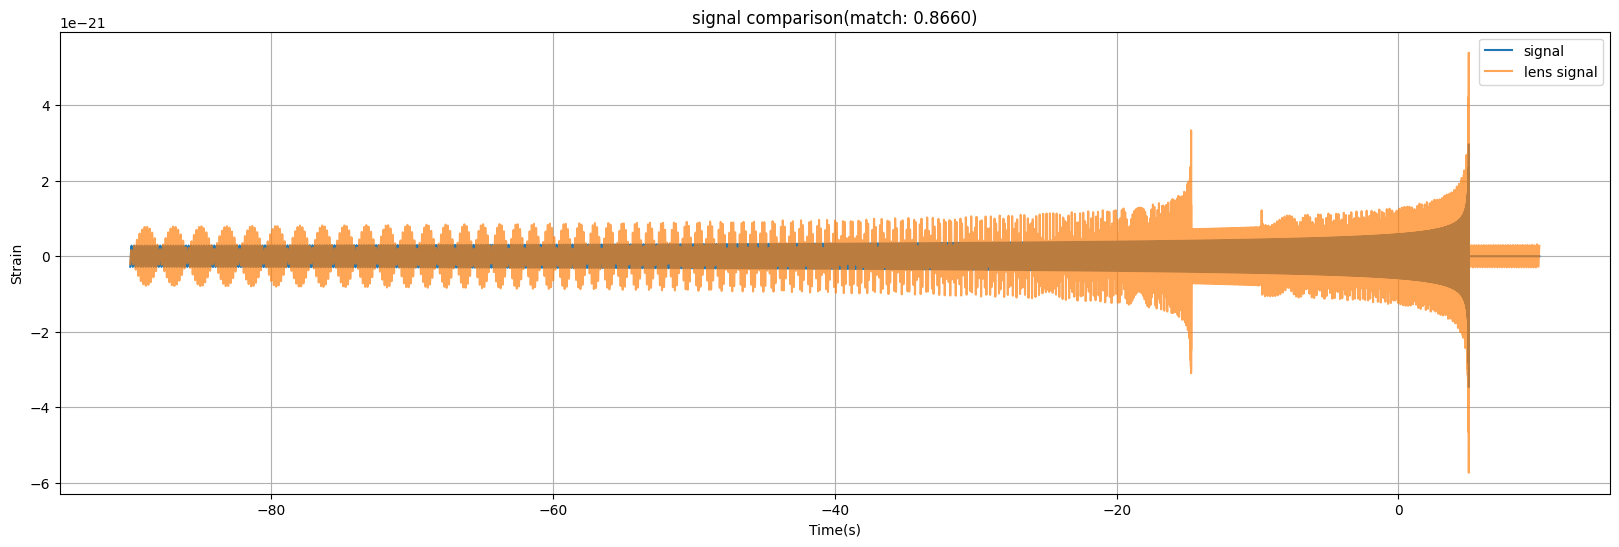

In [27]:
from pycbc.filter import match
# 将NumPy数组转换为PyCBC的TimeSeries对象
delta_t = t[1] - t[0]  # 采样间隔
start_time = t[0]      # 起始时间

# 转换信号为PyCBC的TimeSeries对象
h_pycbc = pycbc.types.TimeSeries(h, delta_t=delta_t, epoch=start_time)
h_lens_pycbc = pycbc.types.TimeSeries(h_lens, delta_t=delta_t, epoch=start_time)

# 计算匹配度
# 设置计算匹配度时使用的参数
f_low = 3.0    # 最低频率
f_high = 1000.0  # 最高频率

# 计算匹配度
match_value, time_offset = match(h_pycbc, h_lens_pycbc, 
                                psd=psdHigh,  # 这里可以加入PSD如果需要
                                low_frequency_cutoff=f_low,
                                high_frequency_cutoff=f_high)

print("\n信号匹配度分析：")
print(f"Match value: {match_value:.4f}")

# 绘图展示原始信号和透镜化信号的对比
plt.figure(figsize=(20, 6))
plt.plot(t, h, label='signal')
plt.plot(t, h_lens, label='lens signal', alpha=0.7)
plt.xlabel('Time(s)')
plt.ylabel('Strain')
plt.title(f'signal comparison(match: {match_value:.4f})')
plt.grid(True)
plt.legend()

In [45]:
import cupy as cp

# 将NumPy数组转换为CuPy数组
data_no_lens_cupy = cp.array(data_no_lens)
data_cupy = cp.array(data)
h_lens_cupy = cp.array(h_lens)
h_cupy = cp.array(h)

# 计算匹配度函数
def innerprodpsd(xVec, yVec, sampFreq, psdVals):
    fftX = cp.fft.fft(xVec)
    fftY = cp.fft.fft(yVec)
    # 确保psdVals也是CuPy数组
    psdVals = cp.array(psdVals)
    psdVec4Norm = cp.concatenate([psdVals, psdVals[-2:0:-1]])
    return cp.real(cp.sum((fftX / psdVec4Norm) * cp.conj(fftY)) / (sampFreq * len(xVec)))

# 计算mismatch
# e1 = 1 - cp.max(innerprodpsd(data_no_lens_cupy, data_cupy, samples, psdHigh) / 
#                cp.sqrt(innerprodpsd(data_no_lens_cupy, data_no_lens_cupy, samples, psdHigh) * 
#                       innerprodpsd(data_cupy, data_cupy, samples, psdHigh)))
e1 = 1 - cp.max(innerprodpsd(h_lens_cupy, data_cupy, samples, psdHigh) / 
               cp.sqrt(innerprodpsd(h_lens_cupy, h_lens_cupy, samples, psdHigh) * 
                      innerprodpsd(data_cupy, data_cupy, samples, psdHigh)))
# e2 = 1 - match_value
print(f'e1:{e1}')

# 计算信噪比
snr = cp.sqrt(innerprodpsd(h_lens_cupy,data_cupy,samples,psdHigh))
# snr = calculate_snr(h_f, freqs, psdHigh, f_low=3.0, f_high=1000.0)

print("\n信噪比分析：")
print(f"Signal-to-Noise Ratio (SNR): {snr:.4f}")
if e1 > snr ** (-2):
    print("透镜")
else :
    print('非透镜')



e1:0.29982869739275375

信噪比分析：
Signal-to-Noise Ratio (SNR): 363.4628
透镜
